## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

## Reference
* https://blog.csdn.net/silent56_th/article/details/72845912

In [16]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [17]:
train, test = keras.datasets.cifar10.load_data()

In [18]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [19]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [26]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [21]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

### 試改變 monitor "Validation Accuracy" 並比較結果

In [22]:
moni = ["val_loss","val_acc"]

In [23]:
for m in moni:
    print(m)

val_loss
val_acc


In [44]:
from keras.callbacks import EarlyStopping
results = {}
# 載入 Callbacks
"""
Earlystop setting
"""
for mo in moni:
    print(mo)
    keras.backend.clear_session() # 把舊的 Graph 清掉
    earlystop = EarlyStopping(monitor=mo, patience=5, verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )
# Collect results
    exp_name_tag = ("monitor=%s" % (mo))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

val_loss
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_

Epoch 13/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.2278 - acc: 0.5778 - val_loss: 1.4793 - val_acc: 0.4761
Epoch 14/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.2029 - acc: 0.5857 - val_loss: 1.4783 - val_acc: 0.4844
Epoch 15/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.1775 - acc: 0.5964 - val_loss: 1.4778 - val_acc: 0.4818
Epoch 16/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.1536 - acc: 0.6036 - val_loss: 1.4781 - val_acc: 0.4828
Epoch 17/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.1307 - acc: 0.6109 - val_loss: 1.4861 - val_acc: 0.4839
Epoch 18/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.1071 - acc: 0.6216 - val_loss: 1.4663 - val_acc: 0.4892
Epoch 19/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.0847 - acc: 0.6286 - val_loss: 1.4764 - val_acc: 0.4807
Epoch 20/50
50000/50000 [=

In [45]:
results.keys()

dict_keys(['monitor=val_loss', 'monitor=val_acc'])

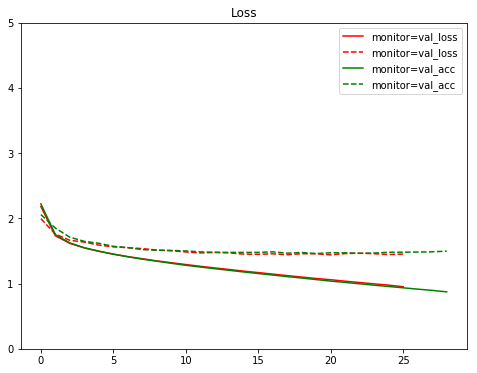

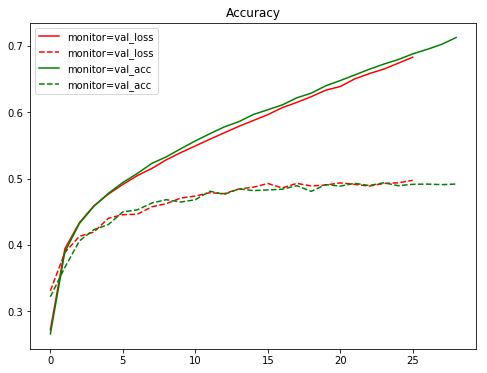

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### 調整 earlystop 的等待次數至 10, 25 並比較結果

In [42]:
wait = [5,10,25]

In [47]:
from keras.callbacks import EarlyStopping
results = {}
# 載入 Callbacks
"""
Earlystop setting
"""
for wa in wait:
    earlystop = EarlyStopping(monitor="val_loss", patience=wa, verbose=1)

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )
# Collect results
    exp_name_tag = ("patience=%s" % (wa))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

Epoch 18/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.1088 - acc: 0.6212 - val_loss: 1.4489 - val_acc: 0.4875
Epoch 19/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.0857 - acc: 0.6296 - val_loss: 1.4535 - val_acc: 0.4845
Epoch 20/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.0629 - acc: 0.6396 - val_loss: 1.4536 - val_acc: 0.4873
Epoch 21/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.0417 - acc: 0.6454 - val_loss: 1.4486 - val_acc: 0.4882
Epoch 22/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.0213 - acc: 0.6537 - val_loss: 1.4511 - val_acc: 0.4924
Epoch 23/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.0016 - acc: 0.6626 - val_loss: 1.4566 - val_acc: 0.4905
Epoch 24/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.9808 - acc: 0.6698 - val_loss: 1.4580 - val_acc: 0.4925
Epoch 25/50
50000/50000 [==

50000/50000 [==============================] - 7s 148us/step - loss: 0.8765 - acc: 0.7090 - val_loss: 1.4895 - val_acc: 0.4945
Epoch 30/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.8556 - acc: 0.7186 - val_loss: 1.4759 - val_acc: 0.5005
Epoch 31/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.8358 - acc: 0.7253 - val_loss: 1.4846 - val_acc: 0.5005
Epoch 32/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.8177 - acc: 0.7318 - val_loss: 1.4792 - val_acc: 0.4979
Epoch 33/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.7988 - acc: 0.7407 - val_loss: 1.4955 - val_acc: 0.4971
Epoch 34/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.7801 - acc: 0.7477 - val_loss: 1.5014 - val_acc: 0.4965
Epoch 35/50
50000/50000 [==============================] - 7s 137us/step - loss: 0.7601 - acc: 0.7556 - val_loss: 1.5216 - val_acc: 0.4942
Epoch 36/50
50000/50000 [==============

In [52]:
results.keys()

dict_keys(['patience=5', 'patience=10', 'patience=25'])

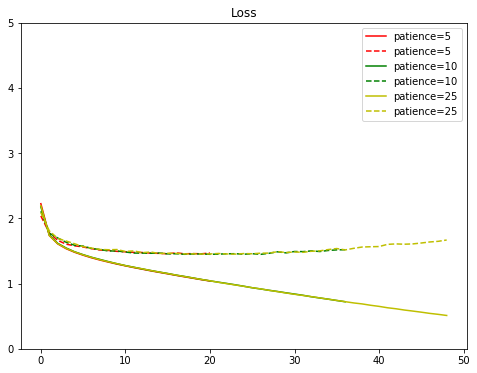

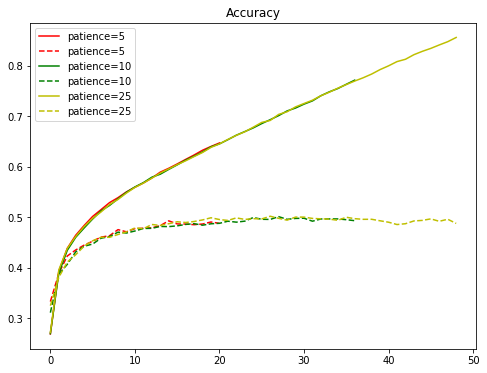

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()